In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Retail Protect 90 Fund

In [3]:
df = pd.read_csv("data.csv", parse_dates=True, index_col = "Dates",sep=';')
print(f"Nombre d'échantillons : {len(df)}")
df

Nombre d'échantillons : 6357


,EONIA Index,SXXR Index
Dates,,
1999-01-04,3.200,358.62
1999-01-05,3.200,363.10
1999-01-06,3.210,371.46
1999-01-07,3.210,367.03
1999-01-08,3.210,368.87
...,...,...
2023-05-10,3.145,1086.08
2023-05-11,3.145,1086.85
2023-05-12,3.148,1091.72


In [4]:
sxxr = df.iloc[:,1]
sxxr = pd.DataFrame(sxxr, columns = ['SXXR Index'])
eonia = df.iloc[:,0]
eonia = pd.DataFrame(eonia, columns = ["EONIA Index"])

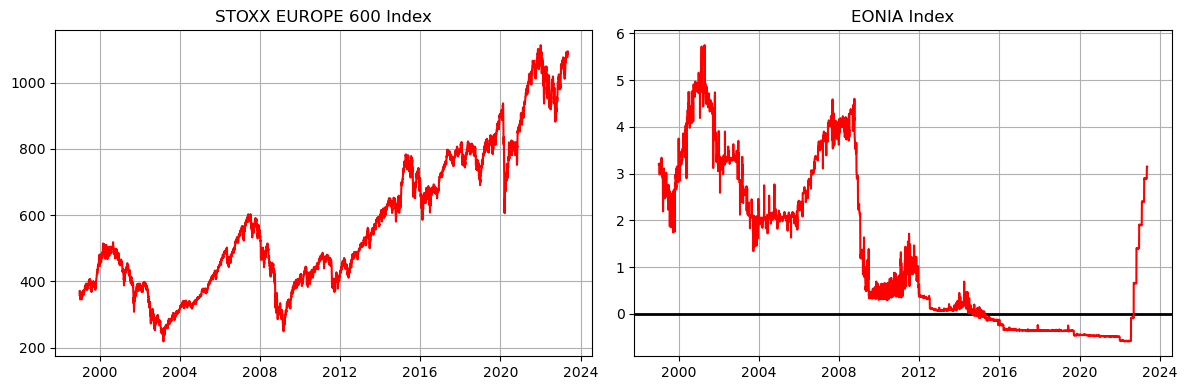

In [5]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr, c="r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(eonia,c="r")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

## Préparation des données

In [6]:
pd.options.mode.chained_assignment = None

In [141]:
def monetarize(df:np.ndarray, nav:float, year:int, horizon:int=0)->pd.DataFrame:
    # Années précédente, à prendre le dernier jour
    tab_prec = df[str(year-1):str(year-1)]
    tab_prec["Loan"] = 100
    tab_prec = pd.DataFrame(tab_prec.iloc[-1]).T
    
    # Années en cours sur un horizon donné
    tab_suiv = df[str(year):str(year+horizon)]
    tab_suiv["Loan"] = 100
    
    tab = pd.concat([tab_prec, tab_suiv])

    rate = [x for x in tab.iloc[:,0]]
    table = np.zeros((len(rate)+1,1))
    table[0] = nav
    compteur = 0
    for elem in rate:
        compteur+=1
        table[compteur] = np.round(table[compteur-1] * (1 + elem/(365*100)),2)
    tab["Loan"] = np.round(table[0:-1],2)
    tab = tab.drop("EONIA Index", axis = 1)
    
    # Year Y
    
    tabl = tab[str(year):str(year+horizon)]
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    tabulate["EONIA Index"] = tabulate
    tabulate = tabulate.drop("Loan", axis = 1)
    
    return tabulate  

def particularyear(df:pd.DataFrame,year):
    tab = df
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T

    # Year Y
    tabl = tab[str(year):str(year)]  
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    return tabulate     
    
    
def normalize(df:pd.DataFrame, year:int, horizon:int=0)->pd.DataFrame:
    """
    This function has only one utility which is to normalize
    the dataframe df (which is the sxxr one) by dividing all the
    dataframe by the first value of sxxr.
    """
    
    S0 = pd.DataFrame(df.iloc[0]).T
    df = round((df/(float(S0.iloc[0,0])))*100,3)
    
    # Year Y-1
    tabn = df[str(year-1):str(year-1)]
    year_last_day = round(pd.DataFrame(tabn.iloc[-1]).T,3)
    
    # Year Y
    tab = df[str(year):str(year+horizon)]
    
    # Concatenate
    tabulate = pd.concat([year_last_day, tab])

    return tabulate

def concat(df1:pd.DataFrame, df2:pd.DataFrame):
    if all(df1.index == df2.index):
        tab = pd.concat([df1,df2],axis =1 )
    else:
        print("Please, be sure both DataFrame have the same index")
    return tab

def VL(df:pd.DataFrame, w:float):
    """
    This function allows to create the NAV dataframe
    The weight "w" should be between 0 and 1
    """
    df1 = pd.DataFrame(df.iloc[:,0]) # eonia
    df2 = pd.DataFrame(df.iloc[:,1]) # sxxr
    n = len(df)
    zer = np.zeros((n,1))
    df["VL"] = zer
    df["VL"] = df["EONIA Index"] * (1-w) + w * df["SXXR Index"]
    val = pd.DataFrame(df["VL"])
    return val

def get_list_protected(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab

w = 0.9
multiplier = 1/w

def protection(df:pd.DataFrame, w:float=0.9):
    tab = df
    # Initialisation des autres colonnes :
    tab["m"] = w
    tab["Risk"] = 0
    tab["No Risk"] = 0
    n = len(tab)
    rang_couss = range(1,n+1)
    tab["Rang Coussin"] = rang_couss

    # Recherche de la première ligne à laquelle le coussin est négative ou nulle
    tabtravail = tab[["Coussin", "Rang Coussin"]]
    liste = []
    date = []
    compteur = 0
    for i in tabtravail.iloc[:,0]:
        compteur += 1
        if i <=0:
            liste.append(compteur)
            dateJ = tabtravail.iloc[compteur-1:compteur].index[0]
            date.append(dateJ)
    date_critique = date[0] # Au cas où l'on souhaite connaitre la date
    coussnegatif = min(liste)-1  # Le rang auquel le premier coussin soit négatif ou nul, -1 car ca commence à 0
    
    if len(date) > 0: # S'il existe une date à laquelle le coussin est négatif ou nul    
        # Mise à jour des colonnes Risk et No Risk

        risk = [x for x in tab["SXXR Index"]]
        norisk = [x for x in tab["EONIA Index"]]

        tab["Risk"] = risk
        tab["No Risk"] = norisk

        allocation = tab[["Risk", "No Risk", "EONIA"]]

        allocation = allocation.iloc[coussnegatif:,]
        allocation["No Risk"] = w*allocation["Risk"] + (1-w)*allocation["No Risk"]
        allocation["Risk"] = 0
    
        # Investir totalement sur l'actif non risqué
        rate = [x for x in allocation["EONIA"]]
        actnorisk = [x for x in allocation["No Risk"]]

        for i in range(len(allocation)):
            if i == 0:
                actnorisk[i] = actnorisk[i]
            else:
                actnorisk[i] = actnorisk[i-1] * (1 + rate[i-1]/(365*100))

        allocation["Actualized no risk"] = actnorisk 
        
        # concat
        
        vl = tab["VL"]
        vl = vl.iloc[:coussnegatif,]
        before = [round(x,3) for x in vl]
        
        after = [round(x,3) for x in allocation["Actualized no risk"]]
        
        all_vl = before + after
        
    #tab = tab.drop(["VL", "SXXR Index", "EONIA Index", "EONIA", "m", "Risk", "No Risk", "Rang Coussin"], axis = 1)
    
    tab["NAV"] = all_vl
    nav = tab["NAV"] #pd.DataFrame(tab["NAV"])
    planch = tab["Plancher"]
    coussin = tab["Coussin"]
    
    tabulate = pd.DataFrame([nav, planch, coussin]).T
        
    
    return tabulate

<AxesSubplot:>

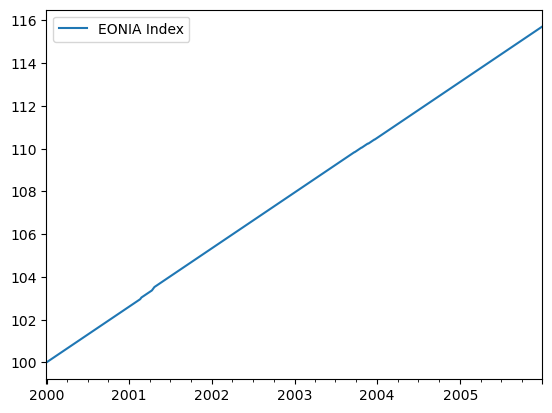

In [142]:
a = monetarize(eonia, 100, 2000, 5)
a.plot()

## CPPI lorsque le poid attribué à l'actif risqué est constant et égal à 90%

<AxesSubplot:>

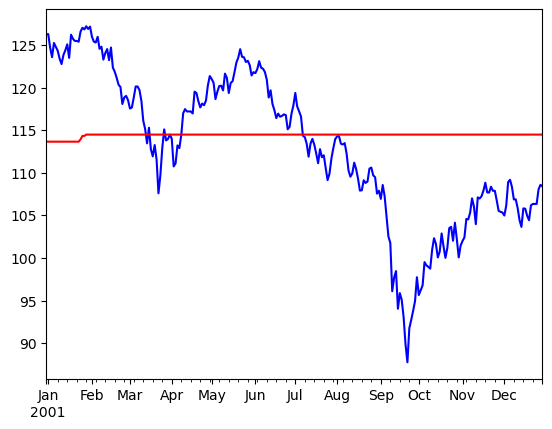

In [155]:
eonia_2000 = monetarize(eonia, 100,2000,5)
sxxr_2000 = normalize(sxxr,2000,5)

sxxr_1 = particularyear(sxxr_2000,2001)
eonia_1 = particularyear(eonia_2000,2001)
df_1 = concat(sxxr_1, eonia_1)

VL_1 = VL(df_1,0.9)
protect = get_list_protected(VL_1,2001,0.9,0)
protect
protect.iloc[:,0].plot(c="b")
protect.iloc[:,1].plot(c="r")

In [144]:
protect

,VL,Plancher,Coussin
2000-12-29,126.2898,113.66082,12.62898
2001-01-01,126.2908,113.66172,12.62908
2001-01-02,124.7006,113.66172,11.03888
2001-01-03,123.5874,113.66172,9.92568
2001-01-04,125.2552,113.66172,11.59348
...,...,...,...
2001-12-25,106.3466,114.49296,-8.14636
2001-12-26,106.3476,114.49296,-8.14536
2001-12-27,108.0622,114.49296,-6.43076
2001-12-28,108.5933,114.49296,-5.89966


In [145]:
w = 0.9
multiplier = 1/w

def protection(df:pd.DataFrame, w:float = 0.9):
    tab = df
    # Initialisation des autres colonnes :
    tab["m"] = w
    tab["Risk"] = 0
    tab["No Risk"] = 0
    n = len(tab)
    rang_couss = range(1,n+1)
    tab["Rang Coussin"] = rang_couss

    # Recherche de la première ligne à laquelle le coussin est négative ou nulle
    tabtravail = tab[["Coussin", "Rang Coussin"]]
    liste = []
    date = []
    compteur = 0
    for i in tabtravail.iloc[:,0]:
        compteur += 1
        if i <=0:
            liste.append(compteur)
            dateJ = tabtravail.iloc[compteur-1:compteur].index[0]
            date.append(dateJ)
    date_critique = date[0] # Au cas où l'on souhaite connaitre la date
    coussnegatif = min(liste)-1  # Le rang auquel le premier coussin soit négatif ou nul, -1 car ca commence à 0
    
    if len(date) > 0: # S'il existe une date à laquelle le coussin est négatif ou nul    
        # Mise à jour des colonnes Risk et No Risk

        risk = [x for x in tab["SXXR Index"]]
        norisk = [x for x in tab["EONIA Index"]]

        tab["Risk"] = risk
        tab["No Risk"] = norisk

        allocation = tab[["Risk", "No Risk", "EONIA"]]

        allocation = allocation.iloc[coussnegatif:,]
        allocation["No Risk"] = w*allocation["Risk"] + (1-w)*allocation["No Risk"]
        allocation["Risk"] = 0
    
        # Investir totalement sur l'actif non risqué
        rate = [x for x in allocation["EONIA"]]
        actnorisk = [x for x in allocation["No Risk"]]

        for i in range(len(allocation)):
            if i == 0:
                actnorisk[i] = actnorisk[i]
            else:
                actnorisk[i] = actnorisk[i-1] * (1 + rate[i-1]/(365*100))

        allocation["Actualized no risk"] = actnorisk 
        
        # concat
        
        vl = tab["VL"]
        vl = vl.iloc[:coussnegatif,]
        before = [round(x,3) for x in vl]
        
        after = [round(x,3) for x in allocation["Actualized no risk"]]
        
        all_vl = before + after
    else:
        all_val = [x for x in tab["VL"]]
        
    #tab = tab.drop(["VL", "SXXR Index", "EONIA Index", "EONIA", "m", "Risk", "No Risk", "Rang Coussin"], axis = 1)
    
    tab["NAV"] = all_vl
    nav = tab["NAV"] #pd.DataFrame(tab["NAV"])
    planch = tab["Plancher"]
    
    tabulate = pd.DataFrame([nav, planch]).T

    
    return tabulate

In [146]:
# Préparation de données

actif = df_1.drop("VL", axis = 1)
donnee = concat(protect, actif)
eonia_2001 = particularyear(eonia, 2001)
eonia_2001 = eonia_2001.rename(columns={"EONIA Index":"EONIA"})
donnee = concat(donnee, eonia_2001)
donnee

,VL,Plancher,Coussin,SXXR Index,EONIA Index,EONIA
2000-12-29,126.2898,113.66082,12.62898,128.922,102.60,5.16
2001-01-01,126.2908,113.66172,12.62908,128.922,102.61,5.16
2001-01-02,124.7006,113.66172,11.03888,127.154,102.62,4.83
2001-01-03,123.5874,113.66172,9.92568,125.916,102.63,4.82
2001-01-04,125.2552,113.66172,11.59348,127.768,102.64,4.81
...,...,...,...,...,...,...
2001-12-25,106.3466,114.49296,-8.14636,106.464,105.29,3.43
2001-12-26,106.3476,114.49296,-8.14536,106.464,105.30,3.43
2001-12-27,108.0622,114.49296,-6.43076,108.368,105.31,3.69
2001-12-28,108.5933,114.49296,-5.89966,108.957,105.32,3.91


In [147]:
riskdata = protection(donnee, 0.1)
riskdata

,NAV,Plancher
2000-12-29,126.290,113.66082
2001-01-01,126.291,113.66172
2001-01-02,124.701,113.66172
2001-01-03,123.587,113.66172
2001-01-04,125.255,113.66172
...,...,...
2001-12-25,106.845,114.49296
2001-12-26,106.855,114.49296
2001-12-27,106.865,114.49296
2001-12-28,106.876,114.49296


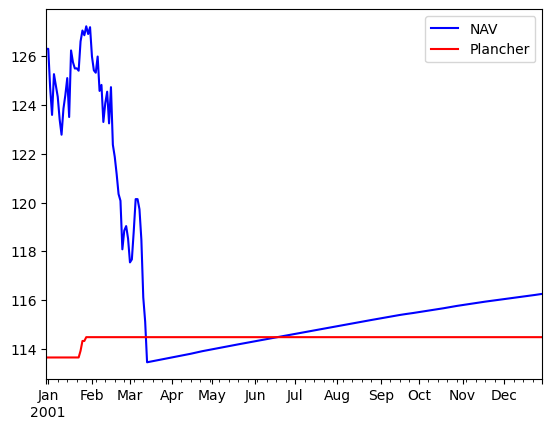

In [14]:
riskdata["NAV"].plot(c="b", legend = "VL")
riskdata["Plancher"].plot(c="r", legend = "Plancher")
plt.legend()

In [15]:
def get_list_protected_nav(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["NAV"] - tab["Plancher"]
        
    return tab

<AxesSubplot:>

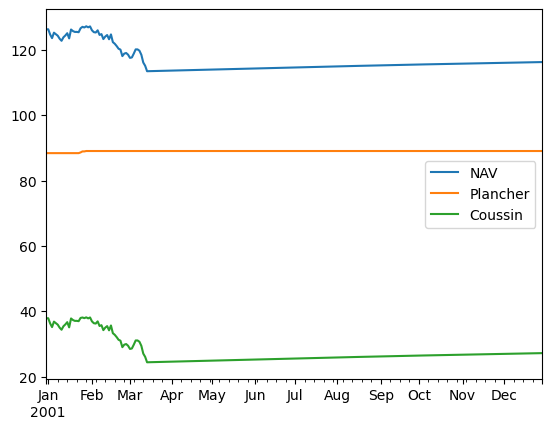

In [133]:
riskdata = pd.DataFrame(riskdata["NAV"])
a = get_list_protected_nav(riskdata,2001,0.7,0)
a.plot()

In [17]:
class CPPI:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
    
    def unifiedata(self, nav:float, year:int, horizon:int):
        eonia = monetarize(self.df2, nav,year,horizon)
        sxxr = normalize(self.df1,year,horizon)
        df = concat(sxxr, eonia)
        return df
    
    def protection(self, nav:float, year:int=2000, horizon:int=0, m:float=0.9):
        df_0 = self.unifiedata(nav,year,0)
        VL_0 = VL(df_0,0.9)
        protect_0 = get_list_protected(VL_0,year,m,0)
        
        return protect_0
    
    def unifiedprotection(self, nav:float,year:int=2000,horizon:int=0,m:float=0.9):
        # Year Y
        df_0 = self.protection(nav,year,0,m)
        df_0 = df_0.drop(df_0.index[-1])
        # Year Y+1
        df_1 = self.protection(nav,year+1,0,m)
        df_1 = df_1.drop(df_1.index[-1])
        # Year Y+2
        df_2 = self.protection(nav,year+2,0,m)
        df_2 = df_2.drop(df_2.index[-1])
        # Year Y+3
        df_3 = self.protection(nav,year+3,0,m)
        df_3 = df_3.drop(df_3.index[-1])
        # Year Y+4 (Final)
        df_4 = self.protection(nav,year+4,0,m)
        
        # Concat :
        df = pd.concat([df_0,df_1,df_2,df_3,df_4],axis=0)
        return df

In [18]:
cppi = CPPI(sxxr, eonia)
data = cppi.unifiedata(100,2000,5)
data

,SXXR Index,EONIA Index
1999-12-31,134.061,100.00
2000-01-03,133.434,100.01
2000-01-04,128.138,100.02
2000-01-05,124.976,100.03
2000-01-06,124.433,100.04
...,...,...
2005-12-26,124.681,115.68
2005-12-27,125.021,115.69
2005-12-28,124.856,115.70
2005-12-29,125.565,115.71


In [19]:
protect = cppi.unifiedprotection(100,2000,0,0.9)
if (min(protect.iloc[:,2]) <= 0):
    print("Faites attention, les coussins peuvent être négatifs ou nuls")
else:
    print("Les coussins sont positifs")


protect

Faites attention, les coussins peuvent être négatifs ou nuls


,VL,Plancher,Coussin
1999-12-31,130.6549,117.58941,13.06549
2000-01-03,130.0916,117.58941,12.50219
2000-01-04,125.3262,117.58941,7.73679
2000-01-05,122.4814,117.58941,4.89199
2000-01-06,121.9937,117.58941,4.40429
...,...,...,...
2004-12-27,98.8368,89.08749,9.74931
2004-12-28,98.9251,89.08749,9.83761
2004-12-29,98.9135,89.08749,9.82601
2004-12-30,98.9127,89.08749,9.82521


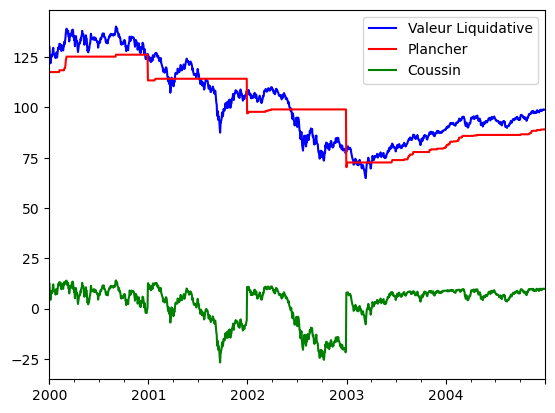

In [20]:
protect.iloc[:,0].plot(c="b", label="Valeur Liquidative")
protect.iloc[:,1].plot(c="r", label="Plancher")
protect.iloc[:,2].plot(c="g", label="Coussin")
plt.legend()

**Remarque** :
- Sur cette période de 5 ans (de 2000 à fin 2004), la VL peut être plus faible que le plancher, qui s'actualise chaque année.
- De ce fait, le coussin peut être négatif

## Protection

In [63]:
def get_list_protected_nav(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["NAV"] - tab["Plancher"]
        
    return tab

In [156]:
class CPPIprotect:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
    
    def unifiedata(self, nav:float=100, year:int=2000, horizon:int=5):
        eonia = monetarize(self.df2, nav,year,horizon)
        sxxr = normalize(self.df1,year,horizon)
        df = concat(sxxr, eonia)
        return df
    
    def get_data(self, nav:float=100, year:int=2000, horizon:int=5, m:float=0.9, h:int = 0, year_initial:int = 2000):
        df = self.unifiedata(nav, year_initial, horizon = 5)
        sxxr = pd.DataFrame(df["SXXR Index"])
        eonia = pd.DataFrame(df["EONIA Index"])
        
        sxxr = particularyear(sxxr, year+h)
        eonia = particularyear(eonia, year+h)
        
        data = concat(sxxr, eonia)
        val = VL(data, m)
        
        protect = get_list_protected(val, year+h, m, 0)
        actif = data.drop("VL", axis = 1)
        donnee = concat(protect, actif)
        
        eonia = particularyear(self.df2,year+h)
        eonia = eonia.rename(columns = {"EONIA Index":"EONIA"})
        donnee = concat(donnee, eonia)

        return donnee
    
    def test(self, nav:float=100, year:int=2000, horizon:int=5, m:float=0.9, h:int = 0, year_initial:int = 2000):
        multiplier = m
        # Year Y  
        df0 = self.get_data(nav, year, horizon, m, h, year_initial)
        riskdata0 = protection(df0, multiplier)
        return riskdata0
    
    def test2(self, nav:float=100, year:int=2000, horizon:int=5, m:float=0.9, h:int = 0, year_initial:int = 2000):
        #multiplier = 1/m
        
        # Year Y
        
        df0 = self.test(nav, year, horizon, m, h, year_initial)
        df0 = pd.DataFrame(df0["NAV"])
        protect0 = get_list_protected_nav(df0,year,m,h)
        protect0 = protect0.drop(protect0.index[-1])
        
        # Year Y+1
        
        df1 = self.test(nav, year, horizon, m, h+1, year_initial)
        df1 = pd.DataFrame(df1["NAV"])
        protect1 = get_list_protected_nav(df1,year+1,m,h)
        protect1 = protect1.drop(protect1.index[-1])
        
        # Year Y+2
        
        df2 = self.test(nav, year, horizon, m, h+2, year_initial)
        df2 = pd.DataFrame(df2["NAV"])
        protect2 = get_list_protected_nav(df2,year+2,m,h)
        protect2 = protect2.drop(protect2.index[-1])
        
        # Year Y+3
        
        df3 = self.test(nav, year, horizon, m, h+2, year_initial)
        df3 = pd.DataFrame(df3["NAV"])
        protect3 = get_list_protected_nav(df3,year+2,m,h)
        protect3 = protect3.drop(protect3.index[-1])
        
        df = pd.concat([protect0, protect1, protect2, protect3], axis = 0)
        
        return df

In [168]:
a = CPPIprotect()
b = a.get_data(100,2000,0,0.8,0,2000)
c = a.get_data(100,2001,0,0.05,0,2000)
#c["VL"].plot()
d = a.test2(100,2000,0,0.2,0,2000)
#d.plot()

#e = get_list_protected_nav(d,2000,0.9,0)
#e
#d = a.testtest(100,2000,0,0.9,1)
#e = a.protec(100,2004,5,0.9,0)
#e.plot()
#f = a.tess(100,2000,5,0.9,0)
#f.plot()
#c.plot()
#c = a.test()
#c.loc["2001", "NAV"].plot(c = "b", label = "NAV")
#c.loc["2001", "Plancher"].plot(c = "r", label = "Plancher")
#plt.legend()

IndexError: list index out of range

In [ ]:
eonia_2000 = monetarize(eonia, 100,2000,5)
sxxr_2000 = normalize(sxxr,2000,5)

sxxr_1 = particularyear(sxxr_2000,2001)
eonia_1 = particularyear(eonia_2000,2001)
df_1 = concat(sxxr_1, eonia_1)

VL_1 = VL(df_1,0.9)
protect = get_list_protected(VL_1,2001,0.9,0)
protect
protect.iloc[:,0].plot(c="b")
protect.iloc[:,1].plot(c="r")

# Préparation de données

actif = df_1.drop("VL", axis = 1)
donnee = concat(protect, actif)
eonia_2001 = particularyear(eonia, 2001)
eonia_2001 = eonia_2001.rename(columns={"EONIA Index":"EONIA"})
donnee = concat(donnee, eonia_2001)
donnee

#riskdata = protection(donnee, multiplier)
#riskdata.plot()